In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

### 1.数据集加载

In [2]:
class MyDataset(Dataset):
    """自定义数据集类"""
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)
        # 随机打乱数据
        self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features = self.data.iloc[idx, :-1].values.astype(np.float32)
        label = self.data.iloc[idx, -1].astype(np.int64)
        label = label - 1
        return torch.tensor(features), torch.tensor(label)
    
# 创建数据集并查看基本信息
dataset = MyDataset("dataset.csv")
print("类别分布:")
print(dataset.data.iloc[:, -1].value_counts().sort_index().rename_axis(None))

# 划分训练集和测试集
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
# # 创建数据加载器
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

类别分布:
1    1000
2    1000
3    1000
4    1000
Name: count, dtype: int64
训练集大小: 3600
测试集大小: 400


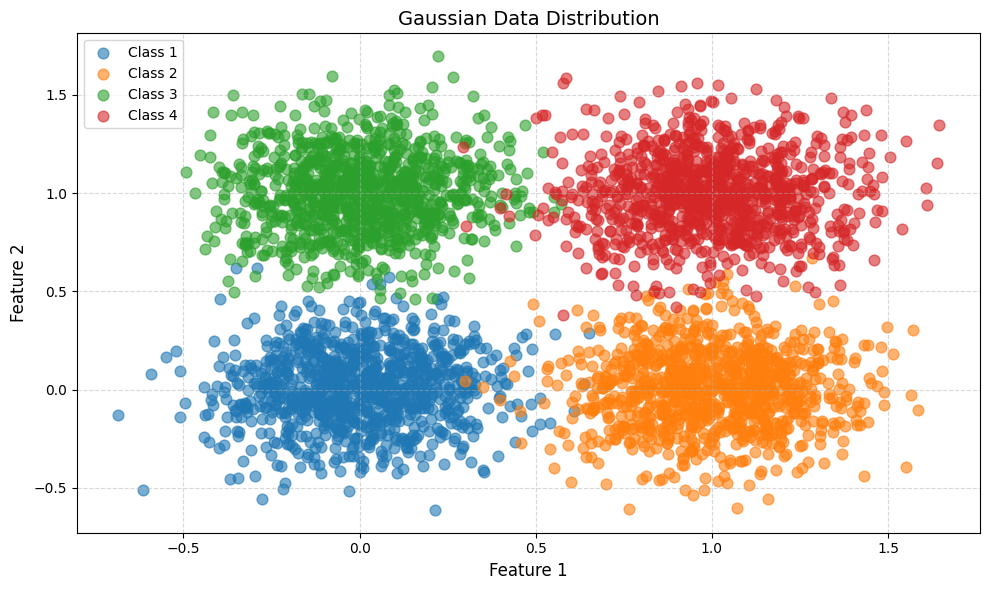

In [3]:
def plot_dataset(dataset):
    """可视化数据集"""
    features = dataset.data.iloc[:, :-1].values
    labels = dataset.data.iloc[:, -1].values
    
    label_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
    
    plt.figure(figsize=(10, 6))
    
    for i, color in enumerate(label_names):
        class_features = features[labels == i + 1]
        plt.scatter(class_features[:, 0], class_features[:, 1], 
                    label=label_names[i], alpha=0.6, s=60)

    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('Gaussian Data Distribution', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_dataset(dataset)

### 2.前馈神经网络

In [4]:
class FeedForwardNN(nn.Module):
    """前馈神经网络"""
    def __init__(
            self, 
            input_size=2, 
            hidden_sizes=[64], 
            output_size=4, 
            activation='relu', 
            dropout_rate=0.0
            ):
        super(FeedForwardNN, self).__init__()
        # 构建网络
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            # 激活函数
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            else:
                layers.append(nn.ReLU())
            # 添加dropout
            if dropout_rate > 0.0:
                layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
        # 保存网络参数
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
    def forward(self, x):
        return self.network(x)
    
def create_model(model_config):
    """根据配置创建模型"""
    return FeedForwardNN(
        input_size=2,
        hidden_sizes=model_config.get('hidden_sizes', [64]),
        output_size=4,
        activation=model_config.get('activation', 'relu'),
        dropout_rate=model_config.get('dropout_rate', 0.0)
    )

### 3.网络训练

In [ ]:
def train_model(model, config, num_epochs=100):
    """训练模型"""
    # 配置信息
    name = config['name']
    batch_size = config.get('batch_size', 32)
    learning_rate = config.get('learning_rate', 0.001)
    
    # 创建日志文件夹和文件
    log_dir = "output"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f"{name}.log")
    
    with open(log_file, "w") as log:
        log.write("Epoch,Train Loss,Train Accuracy,Test Loss,Test Accuracy\n")
    
    # 数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # 记录训练过程
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # 训练循环
    for epoch in tqdm(range(num_epochs), desc=f"Training {config['name']:<12}"):
        # 训练模式
        model.train()
        epoch_train_loss = 0.0
        train_preds = []
        train_labels = []
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            
            # 收集预测结果
            _, predicted = torch.max(output.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(target.cpu().numpy())
        
        # 计算训练损失和准确率
        train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_acc)
        
        # 测试模式
        model.eval()
        epoch_test_loss = 0.0
        test_preds = []
        test_labels = []
        
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target)
                epoch_test_loss += loss.item()
                
                _, predicted = torch.max(output.data, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(target.cpu().numpy())
        
        # 计算测试损失和准确率
        test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(test_loss)
        test_acc = accuracy_score(test_labels, test_preds)
        test_accuracies.append(test_acc)
        
        # 写入日志文件
        with open(log_file, "a") as log:
            log.write(f"{epoch+1},{train_loss:.4f},{train_acc:.4f},{test_loss:.4f},{test_acc:.4f}\n")
    
    # 最终评估
    final_train_accuracy = train_accuracies[-1]
    final_test_accuracy = test_accuracies[-1]
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_train_accuracy': final_train_accuracy,
        'final_test_accuracy': final_test_accuracy,
        'config': config
    }

### 4.绘制结果

In [6]:
def plot_results(results):
    """绘制训练结果"""
    plt.figure(figsize=(20, 5))

    # 训练损失曲线
    ax1 = plt.subplot(141)
    for model_key, result in results.items():
        ax1.plot(result['train_losses'], label=f"{result['config']['name']}")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)

    # 训练准确率曲线
    ax2 = plt.subplot(142)
    for model_key, result in results.items():
        ax2.plot(result['train_accuracies'], label=f"{result['config']['name']}")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)

    # 测试损失曲线
    ax3 = plt.subplot(143)
    for model_key, result in results.items():
        ax3.plot(result['test_losses'], linestyle='--', label=f"{result['config']['name']}")
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Test Loss')
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.5)

    # 测试准确率曲线
    ax4 = plt.subplot(144)
    for model_key, result in results.items():
        ax4.plot(result['test_accuracies'], linestyle='--', label=f"{result['config']['name']}")
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Test Accuracy')
    ax4.legend()
    ax4.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

Training default     : 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


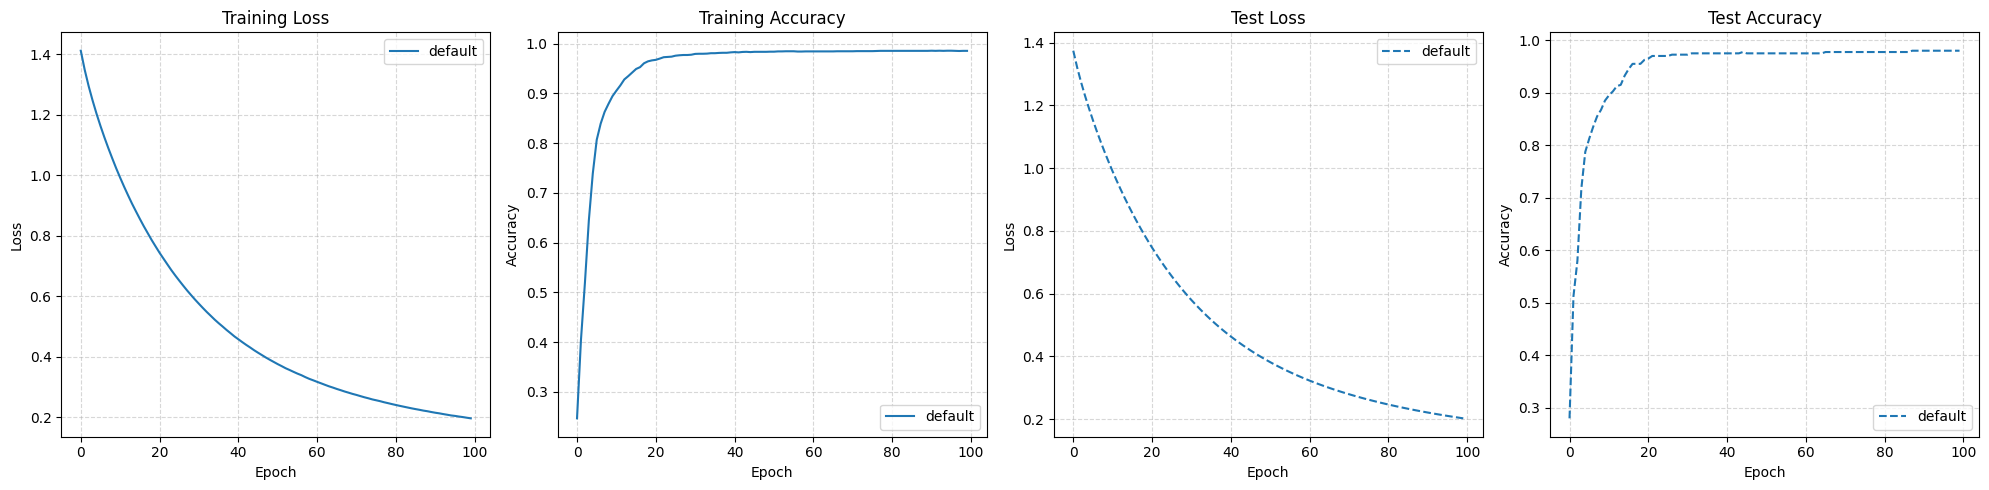

In [7]:
# 默认配置
default_config = {
    'name': 'default',
    'hidden_sizes': [64],
    'activation': 'relu',
    'dropout_rate': 0.0,
    'batch_size': 32,
    'learning_rate': 0.001
}

results = {}
model = create_model(default_config)
results['default'] = train_model(model, default_config, num_epochs=100)
plot_results(results)

Training af_leakyrelu: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


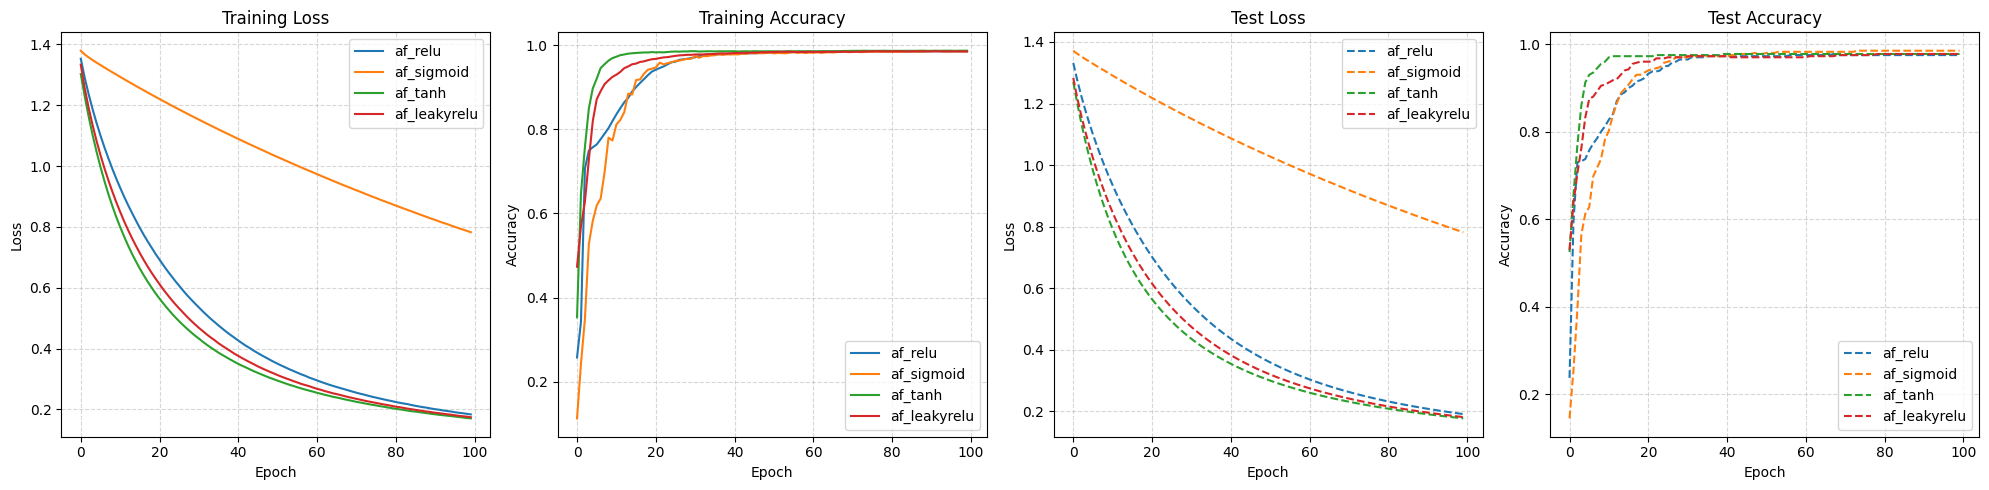

In [8]:
# 不同激活函数
configs = {
    '1': {
        'name': 'af_relu',
        'activation': 'relu'
    },
    '2': {
        'name': 'af_sigmoid',
        'activation': 'sigmoid'
    },
    '3': {
        'name': 'af_tanh',
        'activation': 'tanh'
    },
    '4': {
        'name': 'af_leakyrelu',
        'activation': 'leaky_relu'
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)

Training hs_128      : 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


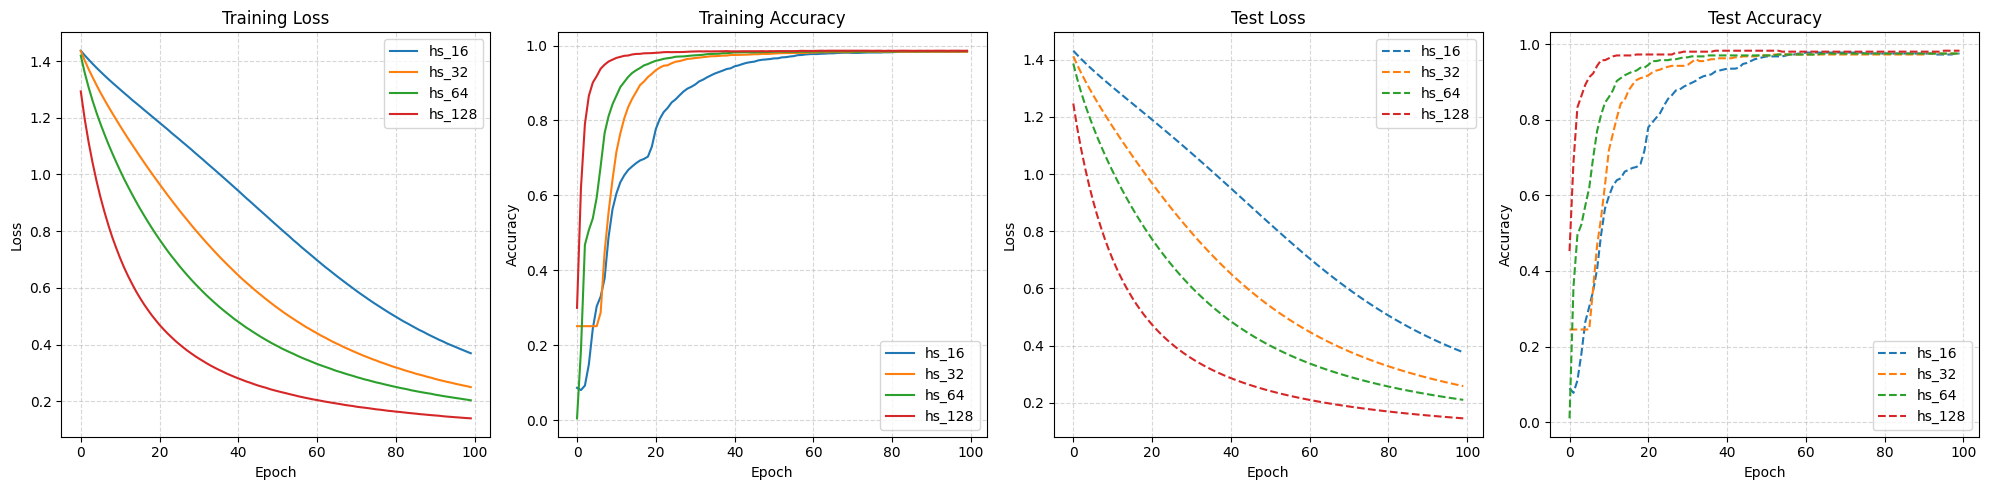

In [9]:
# 不同隐藏层大小
configs = {
    '1': {
        'name': 'hs_16',
        'hidden_sizes': [16]
    },
    '2': {
        'name': 'hs_32',
        'hidden_sizes': [32]
    },
    '3': {
        'name': 'hs_64',
        'hidden_sizes': [64]
    },
    '4': {
        'name': 'hs_128',
        'hidden_sizes': [128]
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)

Training layers_5    : 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


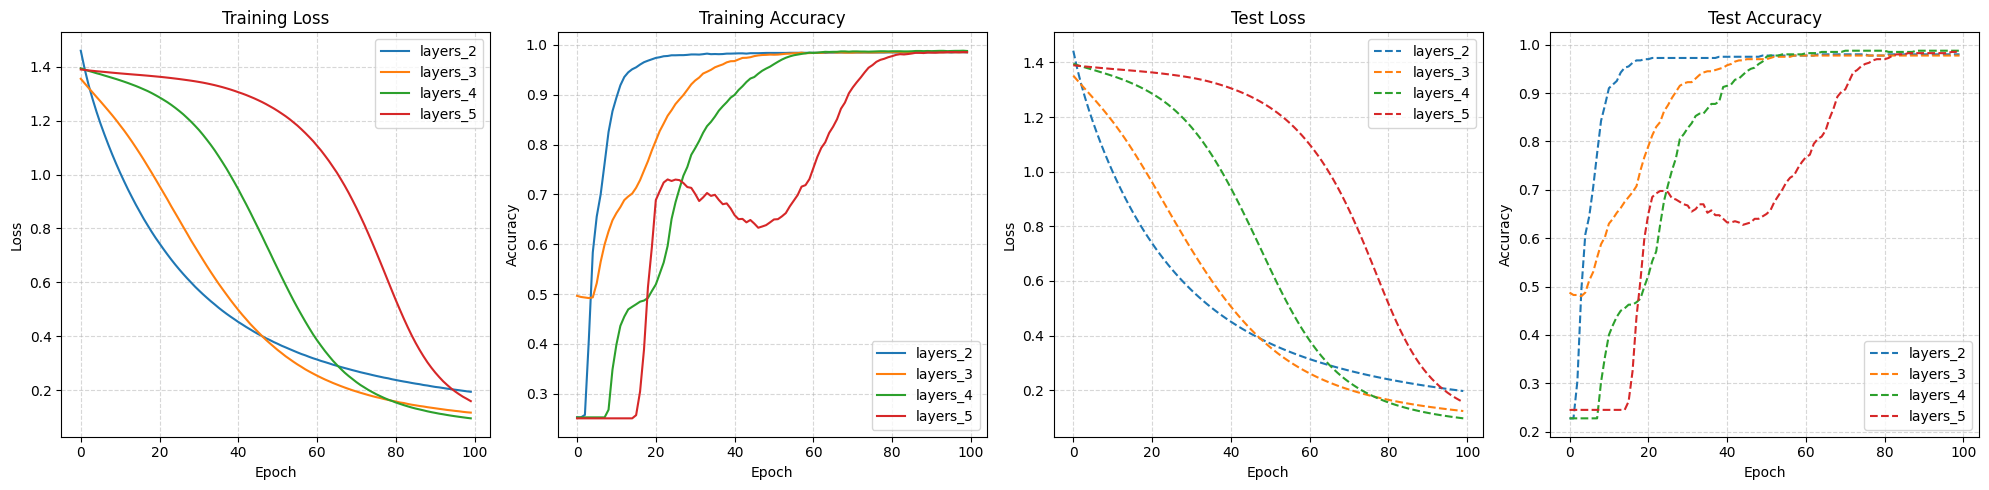

In [10]:
# 不同网络层数
configs = {
    '1': {
        'name': 'layers_2',
        'hidden_sizes': [64]
    },
    '2': {
        'name': 'layers_3',
        'hidden_sizes': [64,64]
    },
    '3': {
        'name': 'layers_4',
        'hidden_sizes': [64,64,64]
    },
    '4': {
        'name': 'layers_5',
        'hidden_sizes': [64,64,64,64]
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)

Training bs_128      : 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


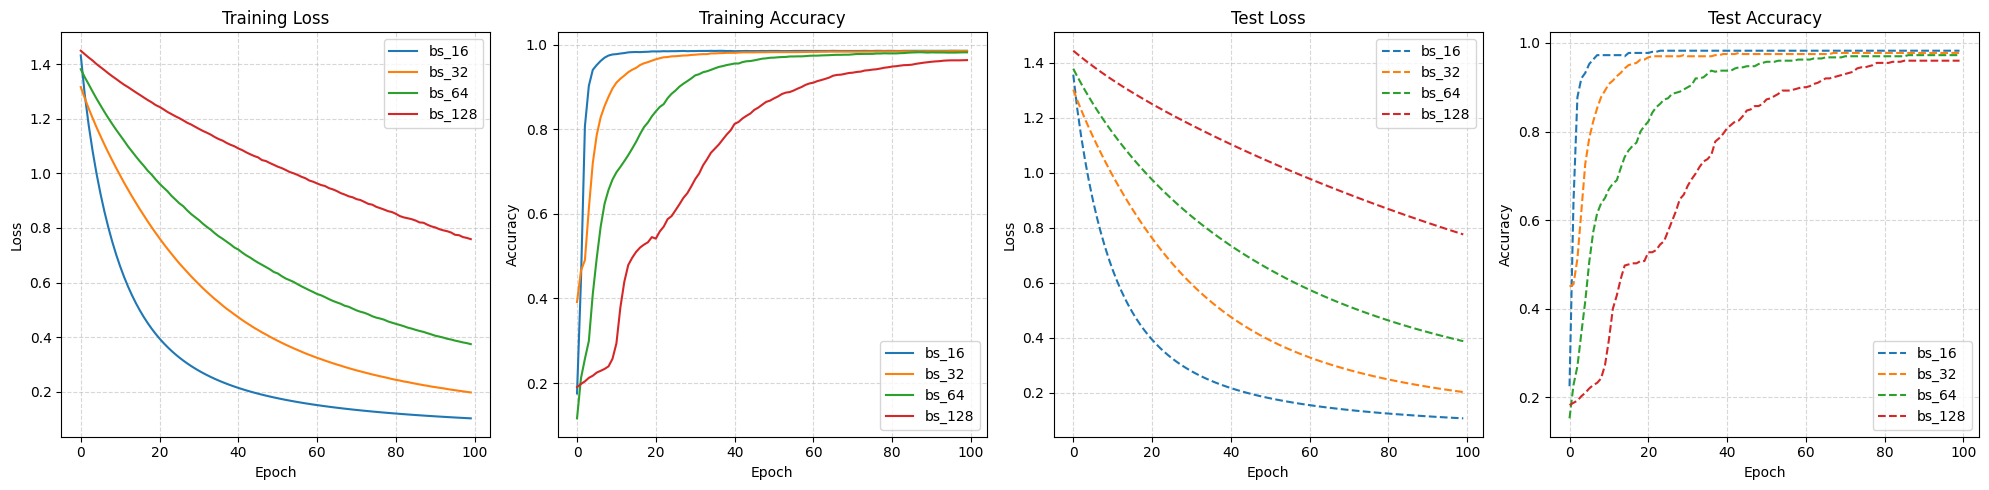

In [11]:
# 不同batch size
configs = {
    '1': {
        'name': 'bs_16',
        'batch_size': 16
    },
    '2': {
        'name': 'bs_32',
        'batch_size': 32
    },
    '3': {
        'name': 'bs_64',
        'batch_size': 64
    },
    '4': {
        'name': 'bs_128',
        'batch_size': 128
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)

Training lr_0.0001   : 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


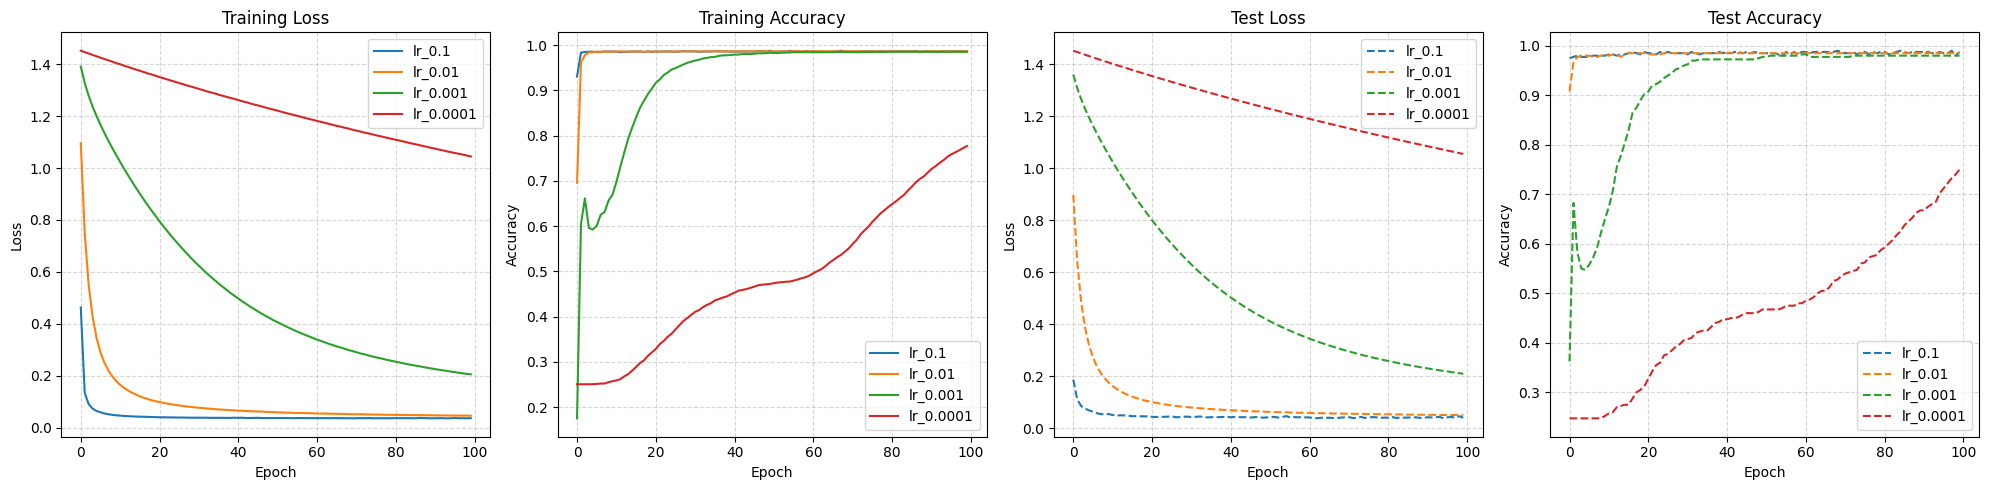

In [12]:
# 不同learning rate
configs = {
    '1': {
        'name': 'lr_0.1',
        'learning_rate': 0.1
    },
    '2': {
        'name': 'lr_0.01',
        'learning_rate': 0.01
    },
    '3': {
        'name': 'lr_0.001',
        'learning_rate': 0.001
    },
    '4': {
        'name': 'lr_0.0001',
        'learning_rate': 0.0001
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)

Training dr_0.3      : 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


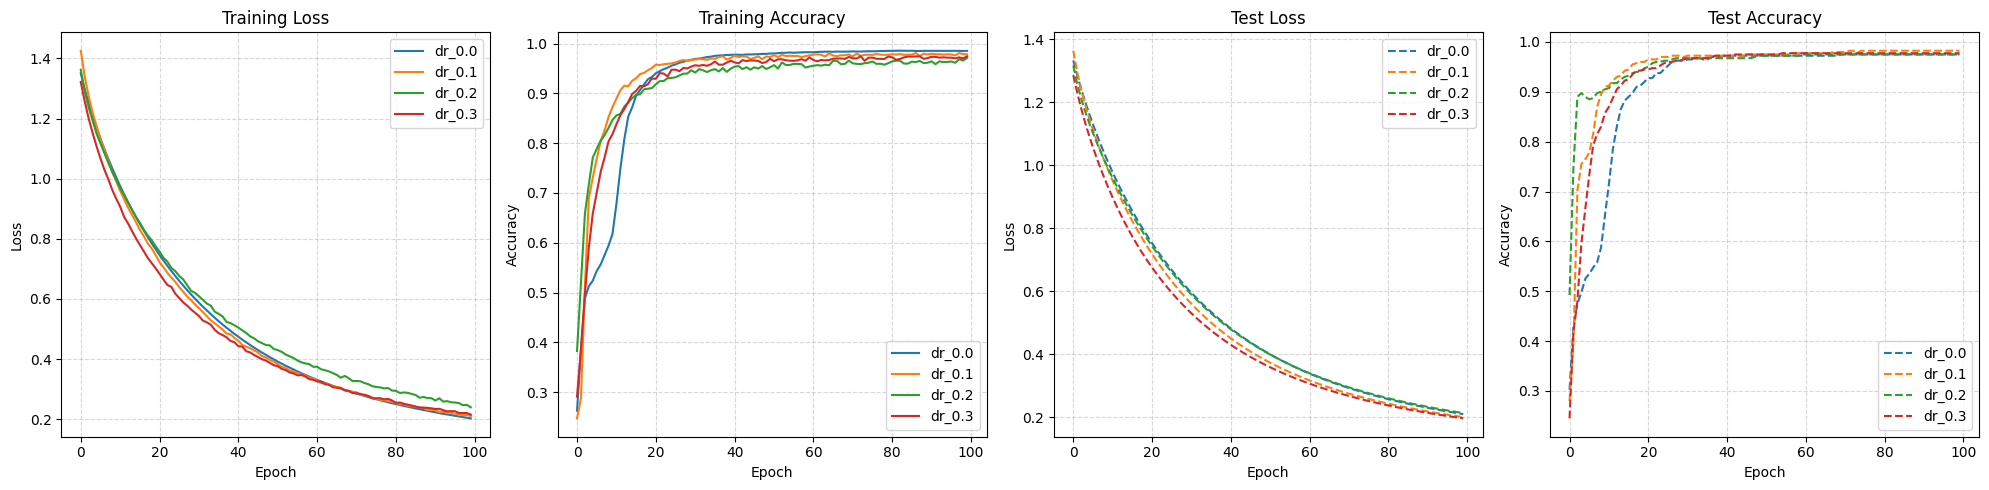

In [13]:
# 不同dropout rate
configs = {
    '1': {
        'name': 'dr_0.0',
        'dropout_rate': 0.0
    },
    '2': {
        'name': 'dr_0.1',
        'dropout_rate': 0.1
    },
    '3': {
        'name': 'dr_0.2',
        'dropout_rate': 0.2
    },
    '4': {
        'name': 'dr_0.3',
        'dropout_rate': 0.2
    }
}

results = {}
for model_key, config in configs.items(): 
    # 创建模型
    model = create_model(config)
    # 训练模型
    results[model_key] = train_model(model, config, num_epochs=100)

plot_results(results)